Reading data from data/network_all_months_plus_25833_length_with_fahrradstrasse.parquet...
Data loaded: 466957 segments
Total length: 15590.50 km
Speed histogram field: 2304-2412_speeds
Length field: length_m


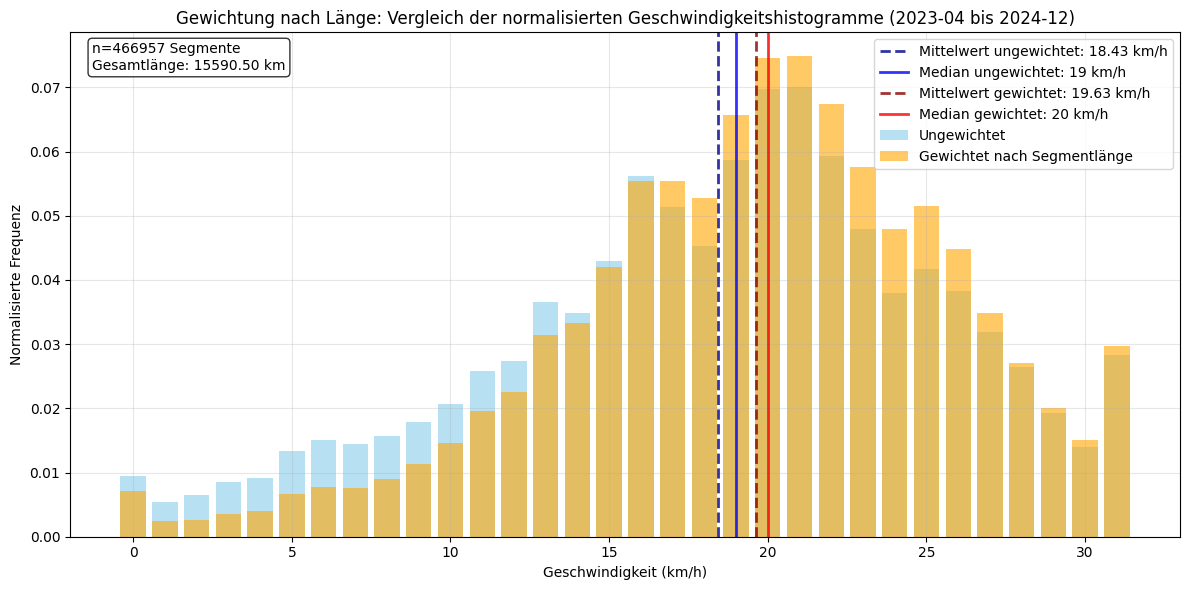


Speed Statistics:
--------------------------------------------------
unweighted_mean: 18.43 km/h
unweighted_median: 19.00 km/h
length_mean: 19.63 km/h
length_median: 20.00 km/h

Analysis complete. Plots saved to: analysis_results/004_Laenge_Gewichtung/


In [1]:
# Geschwindigkeitshistogramme Untersuchungsgebiet, Untersuchungszeitraum: Ungewichtet vs. Gewichtung nach Länge
# Zur Erstellung des Codes wurde die generative Künstliche Intelligenz (KI) „Claude AI“ des Anbieters Anthropic in Version 3.7 genutzt

import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import os

# Configuration variables
INPUT_PARQUET_FILE = "data/network_all_months_plus_25833_length_with_fahrradstrasse.parquet"
OUTPUT_PLOT_PATH = "analysis_results/004_Laenge_Gewichtung/"
SPEED_HISTOGRAM_FIELD = "2304-2412_speeds"  # Using the speed histogram field
LENGTH_FIELD = "length_m"
MAX_SPEED = 32  # Maximum speed value for bins

def analyze_speed_distributions(gdf):
    """Memory-efficient version with consistent rounding"""
    freqs = {
        'unweighted': np.zeros(MAX_SPEED),
        'length': np.zeros(MAX_SPEED)
    }
    
    # Process each row
    for _, row in gdf.iterrows():
        # Parse the speeds array
        try:
            freq_dist = np.array(literal_eval(row[SPEED_HISTOGRAM_FIELD]))
            
            # Ensure the array is the right size (MAX_SPEED)
            if len(freq_dist) < MAX_SPEED:
                padded = np.zeros(MAX_SPEED)
                padded[:len(freq_dist)] = freq_dist
                freq_dist = padded
            elif len(freq_dist) > MAX_SPEED:
                freq_dist = freq_dist[:MAX_SPEED]
                
            freqs['unweighted'] += freq_dist
            freqs['length'] += freq_dist * row[LENGTH_FIELD]
        except (ValueError, SyntaxError, TypeError) as e:
            print(f"Error processing row: {e}")
            continue
    
    # Round all arrays
    for key in freqs:
        freqs[key] = np.round(freqs[key], 2)
    
    return freqs

def calculate_median_from_freq(freqs):
    """Calculate median from frequency distribution"""
    cumsum = np.cumsum(freqs)
    total = cumsum[-1]
    if total == 0:
        return 0
    median_pos = total / 2
    return np.searchsorted(cumsum, median_pos)

def plot_distributions(freqs, output_dir, num_segments, total_length_km):
    """Plot distributions with fixed speed range 0-31"""
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    titles = ['DB Rad+ Unweighted', 'Length-weighted']
    colors = ['skyblue', 'orange']
    
    # Add segment count and total length info
    info_text = f"n={num_segments} Segmente\nGesamtlänge: {total_length_km:.2f} km"
    
    # Calculate statistics for each distribution
    stats = {}
    for key in freqs:
        weights = np.arange(len(freqs[key]))
        stats[f'{key}_mean'] = float(round(np.average(weights, weights=freqs[key]), 2))
        stats[f'{key}_median'] = int(calculate_median_from_freq(freqs[key]))
    
    for ax, (key, title, color) in zip(axes, zip(freqs.keys(), titles, colors)):
        # Plot histogram bars
        ax.bar(np.arange(len(freqs[key])), freqs[key], alpha=0.7, color=color)
        
        # Add mean line and text annotation
        mean_value = stats[f'{key}_mean']
        median_value = stats[f'{key}_median']
        
        # Add mean vertical line
        ax.axvline(mean_value, color='red', linestyle='--', alpha=0.8, linewidth=2)
        
        # Add median vertical line
        ax.axvline(median_value, color='green', linestyle='-', alpha=0.8, linewidth=2)
        
        # Calculate y position for text (at 90% of max height)
        max_height = np.max(freqs[key])
        text_y_pos = max_height * 0.9
        
        # Add text annotations
        ax.text(mean_value + 0.5, text_y_pos, f'Mean: {mean_value:.2f} km/h', 
                color='red', fontweight='bold', ha='left', va='center',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=3))
        
        ax.text(median_value + 0.5, text_y_pos * 0.8, f'Median: {median_value} km/h', 
                color='green', fontweight='bold', ha='left', va='center',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=3))
        
        # Set title and labels
        ax.set_title(f'{title} Speed Distribution')
        ax.set_xlabel('Speed (km/h)')
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)
        
        # Add info text to the top-left corner of each subplot
        ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", 
                facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'speed_distributions.png'), dpi=300)
    plt.close()
    
    # Plot combined distributions for comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Normalize distributions for comparison
    norm_unweighted = freqs['unweighted'] / np.sum(freqs['unweighted'])
    norm_length = freqs['length'] / np.sum(freqs['length'])
    
    # Plot normalized histograms
    ax.bar(np.arange(len(norm_unweighted)), norm_unweighted, alpha=0.6, color='skyblue', label='Ungewichtet')
    ax.bar(np.arange(len(norm_length)), norm_length, alpha=0.6, color='orange', label='Gewichtet nach Segmentlänge')
    
    # Add mean and median lines to the normalized plot
    # For unweighted
    ax.axvline(stats['unweighted_mean'], color='darkblue', linestyle='--', alpha=0.8, 
               linewidth=2, label=f'Mittelwert ungewichtet: {stats["unweighted_mean"]:.2f} km/h')
    ax.axvline(stats['unweighted_median'], color='blue', linestyle='-', alpha=0.8, 
               linewidth=2, label=f'Median ungewichtet: {stats["unweighted_median"]} km/h')
    
    # For length-weighted
    ax.axvline(stats['length_mean'], color='darkred', linestyle='--', alpha=0.8, 
               linewidth=2, label=f'Mittelwert gewichtet: {stats["length_mean"]:.2f} km/h')
    ax.axvline(stats['length_median'], color='red', linestyle='-', alpha=0.8, 
               linewidth=2, label=f'Median gewichtet: {stats["length_median"]} km/h')
    
    ax.set_title('Gewichtung nach Länge: Vergleich der normalisierten Geschwindigkeitshistogramme (2023-04 bis 2024-12)')
    ax.set_xlabel('Geschwindigkeit (km/h)')
    ax.set_ylabel('Normalisierte Frequenz')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Add info text to the top-left corner of the combined plot
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", 
            facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'normalized_speed_distributions.png'), dpi=300)
    plt.show()
    plt.close()
    
    return stats

def main():
    """
    Main function to run the analysis
    """
    print(f"Reading data from {INPUT_PARQUET_FILE}...")
    
    # Read only the necessary columns
    try:
        table = pq.read_table(INPUT_PARQUET_FILE, columns=[SPEED_HISTOGRAM_FIELD, LENGTH_FIELD])
        gdf = table.to_pandas()
        
        # Drop rows with missing values in essential columns
        gdf = gdf.dropna(subset=[SPEED_HISTOGRAM_FIELD, LENGTH_FIELD])
        
        # Calculate total length in kilometers
        total_length_km = gdf[LENGTH_FIELD].sum() / 1000  # Convert from meters to kilometers
        num_segments = len(gdf)
        
        print(f"Data loaded: {num_segments} segments")
        print(f"Total length: {total_length_km:.2f} km")
        print(f"Speed histogram field: {SPEED_HISTOGRAM_FIELD}")
        print(f"Length field: {LENGTH_FIELD}")
        
        # Run analysis
        freqs = analyze_speed_distributions(gdf)
        stats = plot_distributions(freqs, OUTPUT_PLOT_PATH, num_segments, total_length_km)
        
        print("\nSpeed Statistics:")
        print("-" * 50)
        for key, value in stats.items():
            print(f"{key}: {value:.2f} km/h")
        
        # Save stats to CSV
        stats_df = pd.DataFrame([stats])
        stats_df.to_csv(os.path.join(OUTPUT_PLOT_PATH, 'speed_stats.csv'), index=False)
        
        print("\nAnalysis complete. Plots saved to:", OUTPUT_PLOT_PATH)
        return freqs, stats
        
    except Exception as e:
        print(f"Error: {e}")
        return None, None

if __name__ == "__main__":
    main()